In [3]:
%reload_ext autoreload
%autoreload 2

# Imports

In [4]:
from kret_notebook import *  # NOTE import first
from kret_matplotlib.mpl_nb_imports import *
from kret_np_pd.np_pd_nb_imports import *
from kret_polars.polars_nb_imports import *
from kret_rosetta.rosetta_nb_imports import *
from kret_lgbm.lgbm_nb_imports import *
from kret_sklearn.sklearn_nb_imports import *
from kret_torch_utils.torch_nb_imports import *
from kret_lightning.lightning_nb_imports import *
from kret_tqdm.tqdm_nb_imports import *
from kret_type_hints.types_nb_imports import *
from kret_utils.utils_nb_imports import *

# from kret_wandb.wandb_nb_imports import *  # NOTE this is slow to import

Loaded environment variables from /Users/Akseldkw/coding/kretsinger/.env
[kret_matplotlib.mpl_nb_imports] Imported kret_matplotlib.mpl_nb_imports in 0.1946 seconds
[kret_np_pd.np_pd_nb_imports] Imported kret_np_pd.np_pd_nb_imports in 0.0000 seconds
[kret_polars.polars_nb_imports] Imported kret_polars.polars_nb_imports in 0.1828 seconds
[kret_rosetta.rosetta_nb_imports] Imported kret_rosetta.rosetta_nb_imports in 0.0000 seconds
[kret_lgbm.lgbm_nb_imports] Imported kret_lgbm.lgbm_nb_imports in 0.0000 seconds
[kret_sklearn.sklearn_nb_imports] Imported kret_sklearn.sklearn_nb_imports in 0.1391 seconds
[kret_torch_utils.torch_nb_imports] Imported kret_torch_utils.torch_nb_imports in 0.3564 seconds
[kret_lightning.lightning_nb_imports] Imported kret_lightning.lightning_nb_imports in 0.0017 seconds
[kret_tqdm.tqdm_nb_imports] Imported kret_tqdm.tqdm_nb_imports in 0.0000 seconds
[kret_type_hints.types_nb_imports] Imported kret_type_hints.types_nb_imports in 0.0006 seconds
[kret_utils.utils_nb_

# Load Data

In [5]:
df = pd.read_csv(UKS_CONSTANTS.DATA_DIR / "medical_cost.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [7]:
dtt(df)

,Id,age,sex,bmi,children,smoker,region,charges
,int64,int64,object,float64,int64,object,object,float64
401,402,47,male,47.520,1,no,southeast,8083.920
468,469,28,female,24.320,1,no,northeast,23288.928
545,546,49,male,25.840,2,yes,northwest,23807.241
634,635,51,male,39.700,1,no,southwest,9391.346
1081,1082,32,male,27.835,1,no,northwest,4454.403


## Cleanup

In [8]:
UKS_NP_PD.data_cleanup(df)

In [9]:
dtt(df)

,Id,age,sex,bmi,children,smoker,region,charges
,category,int64,category,float64,int64,bool,category,float64
328,329,64,female,33.800,1,True,southwest,47928.030
494,495,21,male,25.700,4,True,southwest,17942.106
618,619,19,female,33.110,0,True,southeast,34439.856
653,654,45,female,36.300,2,False,southeast,8527.532
843,844,57,female,29.810,0,True,southeast,27533.913


In [10]:
df.drop(["Id"], inplace=True, axis=1)

In [11]:
features = df.drop("charges", axis=1)
target = df["charges"]

x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.15, random_state=0)

## Scaler & OLS

In [12]:
dtt(features)

,age,sex,bmi,children,smoker,region
,int64,category,float64,int64,bool,category
792,22,female,23.180,0,False,northeast
877,33,male,33.440,5,False,southeast
979,36,female,29.920,0,False,southeast
1171,43,female,26.700,2,True,southwest
1179,31,male,29.810,0,True,southeast


In [13]:
float_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "region"]

In [14]:
power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)
one_hot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

column_transform = ColumnTransformer(
    transformers=[("scaler", power_transformer, float_cols), ("onehot", one_hot, cat_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
    verbose=True,
)

In [15]:
steps = [("column_transform", column_transform)]

In [16]:
pipeline_x = PipelinePD(steps=steps)

In [17]:
x_train = pipeline_x.fit_transform_df(x_train)
x_val = pipeline_x.transform_df(x_val)

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........ (2 of 3) Processing onehot, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


In [18]:
dtt([x_train, x_val], n=2)

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker
,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
982,-0.518,-0.756,1.367,0.000,1.000,0.000,0.000,0.000,1.000,True
74,0.405,-0.492,0.961,0.000,1.000,0.000,0.000,0.000,1.000,False
,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker
,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
578,0.921,-0.022,0.308,0.000,1.000,0.000,0.000,0.000,1.000,False
1209,1.349,1.041,0.308,0.000,1.000,0.000,0.000,0.000,1.000,False


In [19]:
ols = LinearRegression()
ols.fit(x_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [20]:
y_hat_train_ols = ols.predict(x_train)
resid_train = y_train - y_hat_train_ols
y_hat_val_ols = ols.predict(x_val)
resid_val = y_val - y_hat_val_ols

In [21]:
dtt([x_train, x_val, resid_train, resid_val], n=2)

age 
 bmi 
 children 
 sex_female 
 sex_male 
 region_northeast 
 region_northwest 
 region_southeast 
 region_southwest 
 smoker 
 
 
 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 bool 
 
 
 
 
 643 
 -1.160 
 0.724 
 1.367 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 0.000 
 False 
 
 
 353 
 -0.368 
 0.767 
 -1.072 
 0.000 
 1.000 
 1.000 
 0.000 
 0.000 
 0.000 
 False 
 
 
 
 
 
 
 age 
 bmi 
 children 
 sex_female 
 sex_male 
 region_northeast 
 region_northwest 
 region_southeast 
 region_southwest 
 smoker 
 
 
 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 bool 
 
 
 
 
 787 
 -1.333 
 1.006 
 -1.072 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 0.000 
 False 
 
 
 58 
 0.984 
 -1.315 
 0.308 
 1.000 
 0.000 
 0.000 
 0.000 
 1.000 
 0.000 
 True 
 
 
 
 
 
 
 charges 
 
 
 
 float64 
 
 
 
 
 643 
 -2142.048 
 
 
 353 
 3620.330 
 
 
 
 
 
 
 charges 
 
 
 
 float64 
 
 
 
 
 787 
 -3467.166 
 
 
 58 
 -9346.324

## Build LGBM Dataset

In [22]:
x_train_ds = DatasetLGBM(
    x_train,
)

In [23]:
x_train_ds.set_categorical_feature(cat_cols)

In [24]:
# ds_params = {
#     "feature_name": list(X_train.columns),
#     "categorical_feature": cat_cols,
# }
# train_data = lgbm.Dataset(X_train, label=Y_train, **ds_params)
# test_data = lgbm.Dataset(X_val, label=Y_val, reference=train_data, **ds_params)
# train_data.get_feature_name()
# Implementation

## Train Model

In [25]:
raise ValueError("Stop")

ValueError: Stop

In [26]:
LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'num_leaves': 31,
 'max_depth': 7,
 'learning_rate': 0.1,
 'reg_alpha': 0.001,
 'reg_lambda': 0.001,
 'n_jobs': -2,
 'bagging_fraction': 0.85,
 'feature_fraction': 0.85,
 'min_data_in_leaf': 20}

In [27]:
model = LGBMRegressor(**LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS)

In [28]:
fit_defaults = LGBM_Defaults.LGBM_FIT_DEFAULTS
fit_defaults

{'eval_metric': 'l2',
 'callbacks': [<lightgbm.callback._EarlyStoppingCallback at 0x142fa3380>,
  <lightgbm.callback._RecordEvaluationCallback at 0x1432e2c00>]}

In [29]:
model.fit(x_train, resid_train, eval_set=[(x_val, resid_val)], **LGBM_Defaults.LGBM_FIT_DEFAULTS)

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightG

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [30]:
LGBM_Defaults.EVAL_RECORDS

{'valid_0': OrderedDict([('l2',
               [np.float64(35328767.082793355),
                np.float64(35094110.325391985),
                np.float64(32363609.979229167),
                np.float64(32388512.87358532),
                np.float64(30152393.21556124),
                np.float64(28534521.624512848),
                np.float64(26510018.405024447),
                np.float64(24905647.336782575),
                np.float64(23652808.303602096),
                np.float64(22827377.587658126),
                np.float64(21941042.50217119),
                np.float64(21228548.598477427),
                np.float64(20971271.854482155),
                np.float64(20936743.999246743),
                np.float64(20362619.410138473),
                np.float64(20355685.205568366),
                np.float64(20322854.032737628),
                np.float64(20312848.876486767),
                np.float64(19929286.276428368),
                np.float64(19525049.82260388),
            

In [31]:
# model = lgb.train(
#     params=LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS,  # type:ignore[arg-type]
#     train_set=train_data,
#     valid_sets=[test_data],
#     num_boost_round=1000,
#     callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)],
# )

# NOTE ^ bad performance

In [32]:
y_pred_resid = model.predict(x_val)
y_hat = y_pred_resid + y_hat_val_ols

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [33]:
gs = GroupScatterUKS(y_val, y_pred)

NameError: name 'y_pred' is not defined

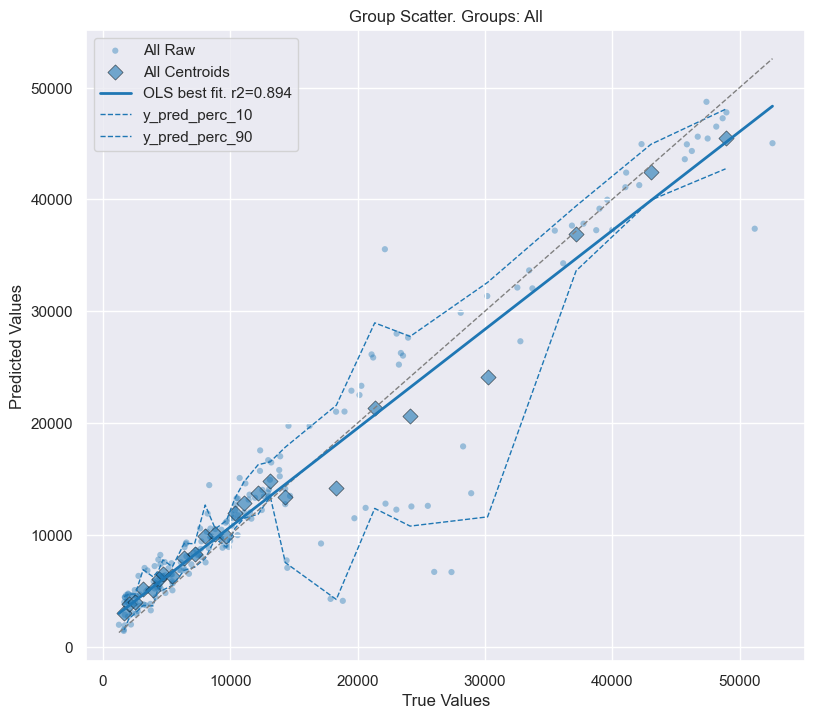

In [ ]:
gs.plot(scatters=("raw", "centroids"), percentiles=(10, 90))

# Sandbox

In [ ]:
gs_resid = GroupScatterUKS(resid_val, y_pred_resid)

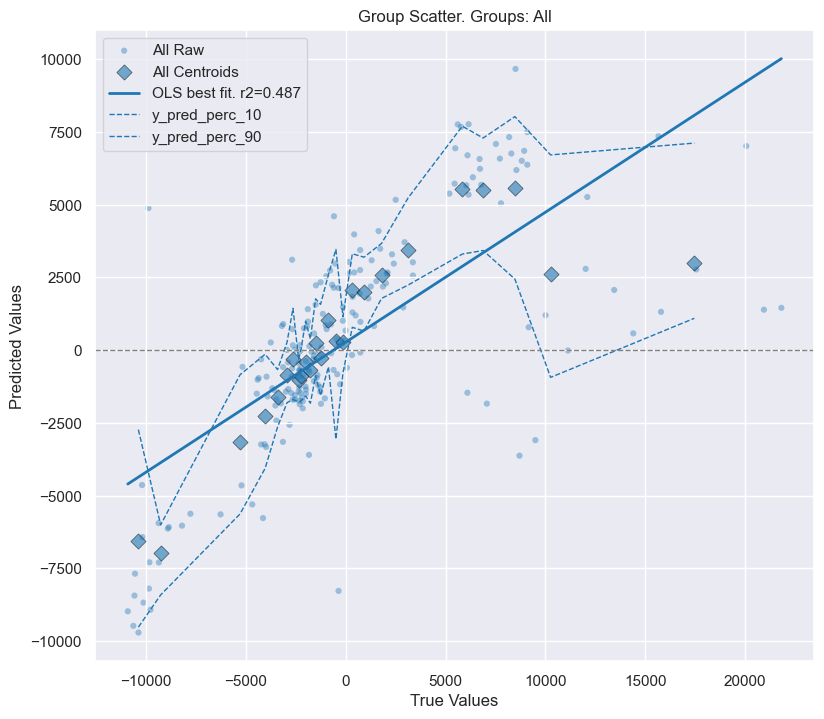

In [ ]:
gs_resid.plot(scatters=("raw", "centroids"), percentiles=(10, 90), addtl_plots="y_0")

In [ ]:
gs_ols = GroupScatterUKS(y_val, y_hat)

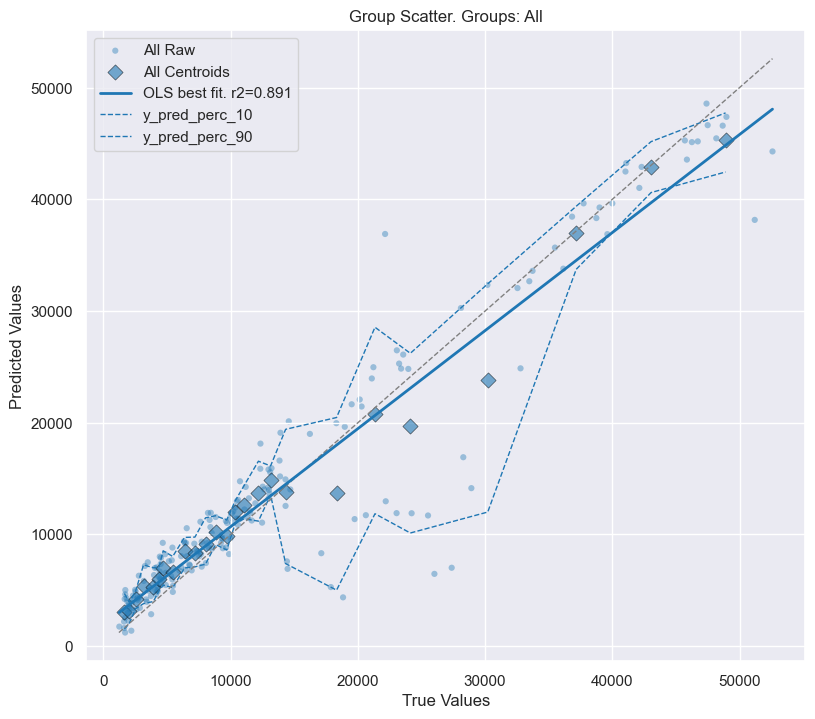

In [ ]:
gs_ols.plot(scatters=("raw", "centroids"), percentiles=(10, 90), addtl_plots="identity")